# Regularization activity
In this activity, you will write add regularization to this model to try to improve its test set performance.

In [2]:
import torch  # Main torch import for torch tensors
import torch.nn as nn  # Neural network module for building deep learning models
import torch.nn.functional as F  # Functional module, includes activation functions
import torch.optim as optim  # Optimization module
import torchvision  # Vision / image processing package built on top of torch

from matplotlib import pyplot as plt  # Plotting and visualization
from sklearn.metrics import accuracy_score  # Computing accuracy metric

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cpu'

# Setup the problem
This is all the same as Week 3 MLP tutorial.

In [6]:
# Any data augmentation should be added to training
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomRotation(15),
    torchvision.transforms.Normalize(mean=0.1307, std=0.3081)
])

# Test data should have normalization applied, but no augmentation
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=0.1307, std=0.3081)
])

# Download the MNIST data and lazily apply the transformation pipeline
train_data = torchvision.datasets.MNIST('./datafiles/', train=True, download=True, transform=train_transform)
test_data = torchvision.datasets.MNIST('./datafiles/', train=False, download=True, transform=test_transform)

# Setup data loaders
# Note: Iterating through the dataloader yields batches of (inputs, targets)
# where inputs is a torch.Tensor of shape (B, 1, 28, 28) and targets is a torch.Tensor of shape (B,)
BATCH_SIZE = 512
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000)

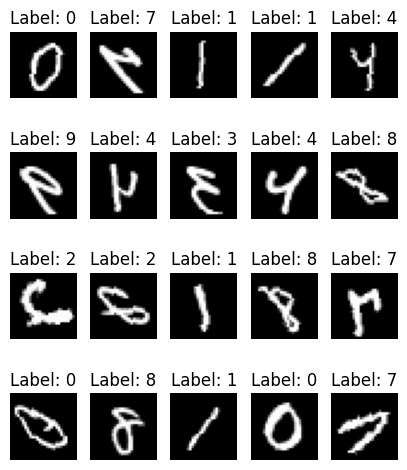

In [7]:
# Plot examples of transformations
fig, axs = plt.subplots(4, 5, figsize=(5, 6))

plot_images = []
plot_labels = []

for i, ax in enumerate(axs.flatten(), start=1000):
    (image, label) = train_data[i]

    # Save this data for later
    plot_images.append(image)
    plot_labels.append(label)

    # Plot each image
    ax.imshow(image.squeeze(), cmap="gray")
    ax.set_title(f"Label: {label}")
    ax.axis("off")
plt.show()

In [8]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Conv layers
        self.input_conv = nn.Conv2d(1, 32, kernel_size=(7, 7), padding=3)
        self.hidden_conv = nn.Conv2d(32, 64, kernel_size=(5, 5), padding=2)
        self.output_conv = nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1)
        # Pool layers
        self.mp1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=1)
        self.mp2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=1)
        # Output layers
        self.output_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.output_layer = nn.Linear(128, 10)
        # Activation
        self.relu = nn.ReLU()
    
    def forward(self, x):
        """
        Forward pass implementation for the network
        
        :param x: torch.Tensor of shape (batch, 1, 28, 28), input images

        :returns: torch.Tensor of shape (batch, 10), output logits
        """
        x = self.input_conv(x)
        x = self.relu(x)
        x = self.mp1(x)
        x = self.hidden_conv(x)
        x = self.relu(x)
        x = self.mp2(x)
        x = self.output_conv(x)
        x = self.relu(x)
        x = self.output_pool(x)
        x = x.squeeze()
        x = self.output_layer(x)
        return x

In [9]:
inputs = torch.randn((4, 1, 28, 28))
model = ConvNet()
logits = model(inputs)
logits.shape

torch.Size([4, 10])

# Setup training loop


In [10]:
def train(model, train_loader, loss_fn, optimizer, epoch=-1):
    """
    Trains a model for one epoch (one pass through the entire training data).

    :param model: PyTorch model
    :param train_loader: PyTorch Dataloader for training data
    :param loss_fn: PyTorch loss function
    :param optimizer: PyTorch optimizer, initialized with model parameters
    :kwarg epoch: Integer epoch to use when printing loss and accuracy
    :returns: Accuracy score
    """
    total_loss = 0
    all_predictions = []
    all_targets = []
    loss_history = []

    model = model.to(DEVICE)
    model.train()  # Set model in training mode

    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets.to(DEVICE))
        loss.backward()
        optimizer.step()


        # Track some values to compute statistics
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=-1)
        all_predictions.extend(preds.detach().cpu().tolist())
        all_targets.extend(targets.cpu().tolist())

        # Save loss every 100 batches
        if (i % 100 == 0) and (i > 0):
            running_loss = total_loss / (i + 1)
            loss_history.append(running_loss)
            # print(f"Epoch {epoch + 1}, batch {i + 1}: loss = {running_loss:.2f}")

    acc = accuracy_score(all_targets, all_predictions)
    final_loss = total_loss / len(train_loader)
    # Print average loss and accuracy
    print(f"Epoch {epoch + 1} done. Average train loss = {final_loss:.2f}, average train accuracy = {acc * 100:.3f}%")
    return acc, final_loss

In [11]:
def test(model, test_loader, loss_fn, epoch=-1):
    """
    Tests a model for one epoch of test data.

    Note:
        In testing and evaluation, we do not perform gradient descent optimization, so steps 2, 5, and 6 are not needed.
        For performance, we also tell torch not to track gradients by using the `with torch.no_grad()` context.

    :param model: PyTorch model
    :param test_loader: PyTorch Dataloader for test data
    :param loss_fn: PyTorch loss function
    :kwarg epoch: Integer epoch to use when printing loss and accuracy

    :returns: Accuracy score
    """
    total_loss = 0
    all_predictions = []
    all_targets = []

    model = model.to(DEVICE)
    model.eval()  # Set model in evaluation mode
    for i, (inputs, targets) in enumerate(test_loader):
        with torch.no_grad():
            outputs = model(inputs.to(DEVICE))
            loss = loss_fn(outputs, targets.to(DEVICE))

            # Track some values to compute statistics
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=-1)
            all_predictions.extend(preds.detach().cpu().tolist())
            all_targets.extend(targets.cpu().tolist())

    acc = accuracy_score(all_targets, all_predictions)
    final_loss = total_loss / len(test_loader)
    # Print average loss and accuracy
    print(f"Epoch {epoch + 1} done. Average test loss = {final_loss:.2f}, average test accuracy = {acc * 100:.3f}%")
    return acc, final_loss

# Test the implementation
Train a model for 5 epochs with both custom and PyTorch optimizer.

In [12]:
LEARNING_RATE = 1e-2
NUM_EPOCHS = 10
WEIGHT_DECAY = 0
torch.manual_seed(0)
model = ConvNet()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE,weight_decay=0)
loss_fn = nn.CrossEntropyLoss()

In [13]:
train_losses = []
test_losses = []
train_metrics = []
test_metrics = []


for epoch in range(NUM_EPOCHS):
    train_acc, train_loss = train(model, train_loader, loss_fn, optimizer, epoch)
    test_acc, test_loss = test(model, test_loader, loss_fn, epoch)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_metrics.append(train_acc)
    test_metrics.append(test_acc)

Epoch 1 done. Average train loss = 1.76, average train accuracy = 36.383%
Epoch 1 done. Average test loss = 1.11, average test accuracy = 60.330%
Epoch 2 done. Average train loss = 1.00, average train accuracy = 65.792%
Epoch 2 done. Average test loss = 0.77, average test accuracy = 72.820%
Epoch 3 done. Average train loss = 0.76, average train accuracy = 74.298%
Epoch 3 done. Average test loss = 0.64, average test accuracy = 78.440%
Epoch 4 done. Average train loss = 0.64, average train accuracy = 78.167%
Epoch 4 done. Average test loss = 0.52, average test accuracy = 81.980%
Epoch 5 done. Average train loss = 0.56, average train accuracy = 81.048%
Epoch 5 done. Average test loss = 0.45, average test accuracy = 83.590%
Epoch 6 done. Average train loss = 0.50, average train accuracy = 83.120%
Epoch 6 done. Average test loss = 0.40, average test accuracy = 86.390%
Epoch 7 done. Average train loss = 0.47, average train accuracy = 84.517%
Epoch 7 done. Average test loss = 0.38, average te

# Plot the training curve, did overfitting improve?

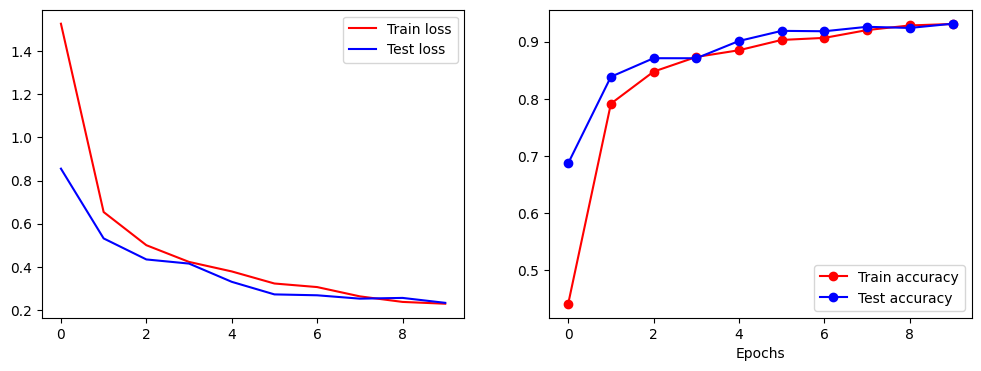

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(train_losses, c="r", label="Train loss")
axs[0].plot(test_losses, c="b", label="Test loss")
axs[0].legend()
axs[1].set_xlabel("Epochs")

axs[1].plot(train_metrics, "o-", c="r", label="Train accuracy")
axs[1].plot(test_metrics, "o-", c="b", label="Test accuracy")
axs[1].legend()
axs[1].set_xlabel("Epochs")

plt.show()